# Introducción a Dask

Dask es una biblioteca de python diseñada para cómputo científico/analítico en gran escala. Existen dos grandes componentes de  Dask:

1. **Cómputo de tareas**: Para ejecutar un _workflow_ o _pipeline_ de tareas en paralelo. Esto es similar a Airflow o Luigi, pero de "bajo nivel".
2. **Grandes datos**: Datos que no quepan en memoria o no se puedan procesar cómodamente en una computadora personal. Dask provee una solución similar a Spark, pero con sintáxis de pandas/numpy. Este componente está construido sobre el anterior

## ¿Por qué Dask?

![](resources/growth.png)

* API Familiar (parecido a numpy/pandas)
* Python no es un extra 
* Escala fácilmente y de manera flexible
* Desarrollo constante 
* Comunidad activa

## Dask vs Spark

### Lenguaje
* Spark está escrito en Scala con soporte (secundario) para Python y R. Puede utilizar código para la JVM
* Dask está escrito en Python y sólo soporta Python. Puede utilizar código de C/C++/Fortran a través de las integraciones con Python

### Ecosistema
* Spark es parte de un ecosistema inspirado en el (Sparkling Water, Spark ML, etc). "Juega bonito" con otros proyectos de Apache
* Dask es parte del ecosistema Python. "Juega bonito" con otras librerías de Python como pandas, numpy, etc

### Edad y Confianza
* Spark es más viejo y maduro (2010), y por lo tanto se ha ganado un lugar en la industria
* Dask es más joven (2014) y en desarrollo constante, pero intenta ser una extensión de otras librerías confiables como numpy/pandas

### Alcance
* Spark está diseñado para trabajar con abstracciones de alto nivel. Tareas típicas de BI y queries SQL son sus principales casos de uso
* Dask está pensado para trabajar a un nivel más bajo. Paralelizar y ejecutar tareas arbitrarias es uno de sus objetivos, aunque también incluye algunas abstracciones de alto nivel.

### Escoge Spark si...
* Prefieres Scala o SQL
* Necesitas operar con código basado en la JVM
* Quieres una solución establecida y robusta para producción
* Necesitas programar ETLs sencillos
* Principalmente realizas tareas de BI con un poco de ML

### Escoge Dask si...
* Prefieres Python o código nativo (C/Fortran)
* Tu caso de uso es complejo y no es fácil de manejar en Spark
* Prefieres un proyecto más ligero que te permita realizar cómputo en paralelo


## Conéctandonos al cluster

In [1]:
from dask.distributed import Client

client = Client()
client

/home/arinarmo/miniconda3/envs/daskintro/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/arinarmo/miniconda3/envs/daskintro/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://127.0.0.1:42883 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.68 GB


La manera de distribuir trabajo en Dask es similar a Spark. Tenemos un sólo _scheduler_ que se encarga de agendar las tareas y distribuirlas a los _workers_ activos. Esto nos permite escalar a cientos de CPUs.

![](resources/workers.png)

Dask también nos permite monitorear recursos del sistema

![](resources/system.png)

También nos permite monitorear la ejecución de tareas

![](resources/task_stream.png)

Al igual que en Spark, podemos crear un cliente dirigiéndonos simplemente a la dirección del _scheduler_

## Computo _Lazy_ y en paralelo



Con Dask podemos generar una "receta" para la ejecución de tareas, sin ejecutarla en ese momento. Esto nos permite no "bloquear" nuestro programa y es lo que permite la paralelización

In [2]:
from dask import delayed

# Decoramos nuestras funciones con `delayed`, para indicar que no se deben ejecutar en este momento

@delayed
def inc1(x):
    return x + 1


@delayed
def mul2(x):
    return x*2


@delayed
def add(x, y):
    return x + y

# Creamos la "receta" de ejecución
x = inc1(15)
y = mul2(7)
total = add(x, y)
total

Delayed('add-21440e23-5ad2-4d09-86d2-0f242652aad1')

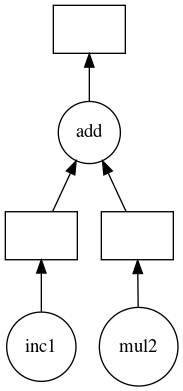

In [3]:
# Podemos visualizar el grafo de tareas generado por esta receta
total.visualize()

In [4]:
# Realizamos el cómputo de la tarea
result = total.compute()
print(result)

# O bien, lo realizamos de manera remota 
computed = client.compute(total) # Esto no bloquea
computed.result()

30


30

In [5]:
import numpy as np

def sequential(s):
    a = np.random.normal(0, 1, s)
    b = np.random.normal(5, 3, s)
    c = np.random.normal(7, 2, s)
    
    return np.percentile(a, 80) + np.percentile(b, 60) + np.percentile(c, 99)

delayed_normal = delayed(np.random.normal)
delayed_percentile = delayed(np.percentile)
def in_parallel(s):
    a = delayed_normal(0, 1, s)
    b = delayed_normal(5, 3, s)
    c = delayed_normal(7, 2, s)

    return (delayed_percentile(a, 80) + delayed_percentile(b, 60) + delayed_percentile(c, 99)).compute()

print("Sequential:")
%time sequential(int(1e7))

print("Parallel:")
%time in_parallel(int(1e7))

Sequential:
CPU times: user 2.55 s, sys: 152 ms, total: 2.7 s
Wall time: 1.58 s
Parallel:
CPU times: user 338 ms, sys: 8.27 ms, total: 346 ms
Wall time: 674 ms


18.257084892266555

In [6]:
params = [(0, 1), (5, 3), (7, 2)]
percentiles = [80, 60, 99]
def in_parallel(s, params, percentiles):
    normal_samples = [delayed_normal(p[0], p[1], s) for p in params]
    return sum([delayed_percentile(sample, p) for sample, p in zip(normal_samples, percentiles)]).compute()
    
%time in_parallel(int(1e7), params, percentiles)

CPU times: user 24.3 ms, sys: 15 ms, total: 39.3 ms
Wall time: 634 ms


18.257084892266555

* ¿Cómo cambia este resultado con el parámetro de tamaño `s`? ¿Por qué?
* ¿Cómo cambiarías la función para usar ciclos y parámetros (de la normal y percentiles)?

In [7]:
# Ejercicio: escribe una función para checar si un número es primo y pruébala con los sig. numeros. 
#  Después, ejecuta el ciclo en paralelo y compara el tiempo de ejecución de ambos métodos
import math
nums = [7961147, 1627785787, 402938420121, 2093482093844387, 
        211236347099, 3718687359123, 871144421117, 650280751121]

def is_prime(n):
    '''Checa si n es primo o no'''
    # Hint: sólo tienes que checar los factores hasta la raíz cuadrada de n
    return False

%time [is_prime(n) for n in nums]

delayed_is_prime = delayed(is_prime)
%time [delayed_is_prime(n).compute() for n in nums]

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.4 µs
CPU times: user 41.7 ms, sys: 6.6 ms, total: 48.3 ms
Wall time: 81.4 ms


[False, False, False, False, False, False, False, False]

## _Bags_

Los _bags_ de Dask están diseñados para lidiar con datos semi-estructurados o no estructurados (e.g. documentos JSON, texto plano). Son análogos a los RDD de Spark y proveen una abstracción a los conceptos de `map`, `filter`, etc.

In [10]:
from dask import bag

taxis = bag.read_text("../data/taxis.json")

# Cada línea es un JSON en texto
print(taxis.take(1))

('{"trips": [{"tpep_pickup_datetime": "2015-01-03 01:17:32", "trip_distance": 6.9, "tip_amount": 4.6, "tpep_dropoff_datetime": "2015-01-03 01:37:02", "passenger_count": 1, "fare_amount": 22.0}, {"tpep_pickup_datetime": "2015-01-05 23:25:15", "trip_distance": 1.81, "tip_amount": 0.0, "tpep_dropoff_datetime": "2015-01-05 23:35:02", "passenger_count": 1, "fare_amount": 9.0}, {"tpep_pickup_datetime": "2015-01-06 15:11:45", "trip_distance": 0.96, "tip_amount": 1.0, "tpep_dropoff_datetime": "2015-01-06 15:22:12", "passenger_count": 1, "fare_amount": 7.5}, {"tpep_pickup_datetime": "2015-01-08 08:22:12", "trip_distance": 1.9, "tip_amount": 1.0, "tpep_dropoff_datetime": "2015-01-08 08:31:23", "passenger_count": 1, "fare_amount": 8.5}, {"tpep_pickup_datetime": "2015-01-08 12:26:26", "trip_distance": 1.0, "tip_amount": 1.66, "tpep_dropoff_datetime": "2015-01-08 12:35:54", "passenger_count": 1, "fare_amount": 7.5}, {"tpep_pickup_datetime": "2015-01-10 21:51:09", "trip_distance": 1.71, "tip_amount"

In [11]:
import json
taxis = taxis.map(json.loads) # Lazy!
taxis.take(1) #Sólo ejecuta un `json.loads`

({'trips': [{'tpep_pickup_datetime': '2015-01-03 01:17:32',
    'trip_distance': 6.9,
    'tip_amount': 4.6,
    'tpep_dropoff_datetime': '2015-01-03 01:37:02',
    'passenger_count': 1,
    'fare_amount': 22.0},
   {'tpep_pickup_datetime': '2015-01-05 23:25:15',
    'trip_distance': 1.81,
    'tip_amount': 0.0,
    'tpep_dropoff_datetime': '2015-01-05 23:35:02',
    'passenger_count': 1,
    'fare_amount': 9.0},
   {'tpep_pickup_datetime': '2015-01-06 15:11:45',
    'trip_distance': 0.96,
    'tip_amount': 1.0,
    'tpep_dropoff_datetime': '2015-01-06 15:22:12',
    'passenger_count': 1,
    'fare_amount': 7.5},
   {'tpep_pickup_datetime': '2015-01-08 08:22:12',
    'trip_distance': 1.9,
    'tip_amount': 1.0,
    'tpep_dropoff_datetime': '2015-01-08 08:31:23',
    'passenger_count': 1,
    'fare_amount': 8.5},
   {'tpep_pickup_datetime': '2015-01-08 12:26:26',
    'trip_distance': 1.0,
    'tip_amount': 1.66,
    'tpep_dropoff_datetime': '2015-01-08 12:35:54',
    'passenger_count': 

In [12]:
# Filter
b_type = taxis.filter(lambda d: d["car_type"] == "B")
print("Autos tipo B: {}".format(b_type.count().compute()))

Autos tipo B: 297


In [13]:
# Pluck
print("Primeros 10 ids: {}".format(taxis.pluck("taxi_id").take(10)))

Primeros 10 ids: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


In [14]:
# Aplasta
trips = taxis.pluck("trips").flatten()
trips.take(5)

({'tpep_pickup_datetime': '2015-01-03 01:17:32',
  'trip_distance': 6.9,
  'tip_amount': 4.6,
  'tpep_dropoff_datetime': '2015-01-03 01:37:02',
  'passenger_count': 1,
  'fare_amount': 22.0},
 {'tpep_pickup_datetime': '2015-01-05 23:25:15',
  'trip_distance': 1.81,
  'tip_amount': 0.0,
  'tpep_dropoff_datetime': '2015-01-05 23:35:02',
  'passenger_count': 1,
  'fare_amount': 9.0},
 {'tpep_pickup_datetime': '2015-01-06 15:11:45',
  'trip_distance': 0.96,
  'tip_amount': 1.0,
  'tpep_dropoff_datetime': '2015-01-06 15:22:12',
  'passenger_count': 1,
  'fare_amount': 7.5},
 {'tpep_pickup_datetime': '2015-01-08 08:22:12',
  'trip_distance': 1.9,
  'tip_amount': 1.0,
  'tpep_dropoff_datetime': '2015-01-08 08:31:23',
  'passenger_count': 1,
  'fare_amount': 8.5},
 {'tpep_pickup_datetime': '2015-01-08 12:26:26',
  'trip_distance': 1.0,
  'tip_amount': 1.66,
  'tpep_dropoff_datetime': '2015-01-08 12:35:54',
  'passenger_count': 1,
  'fare_amount': 7.5})

In [15]:
# Algunas operaciones se pueden aplicar directamente
(trips.pluck("fare_amount")
      .mean()
      .compute())

11.864121548162636

### Group By
Agrupa los elementos del bag de acuerdo a la evaluación de alguna función "llave"

In [16]:
b = bag.from_sequence(list(range(10)))
b.groupby(lambda x: x % 3).compute()

[(0, [0, 3, 6, 9]), (1, [1, 4, 7]), (2, [2, 5, 8])]

### Fold By

Agrupa y **reduce** de acuerdo a la evaluación de alguna función. Cumple un propósito similar a `reduceByKey` o `combineByKey` de Spark.

Necesita 3 cosas:

1. Una función "llave" para agrupar los elementos
2. Una función binaria para reducir elementos por pares
3. Una función binaria para reducir el resultado de dos reducciones

In [17]:
%%time

def incr(x, y):
    return x + 1

def add(x, y):
    return x + y

print(trips.foldby(key=lambda x: x["tip_amount"] > 10, # Si el tip es > 10 o no
              binop=incr, # Incrementa 1 por obs
              initial=0, 
              combine=add, # Suma cada cuenta
              combine_initial=0)
       .compute())

[(False, 9082), (True, 116)]
CPU times: user 21.9 ms, sys: 33 µs, total: 22 ms
Wall time: 45.4 ms


In [19]:
%%time

(trips.groupby(grouper=lambda x: x["tip_amount"] > 10, shuffle="disk")
      .starmap(lambda k, v: (k, len(v)))
      .compute())

CPU times: user 86 ms, sys: 2.23 ms, total: 88.2 ms
Wall time: 738 ms


[(False, 9082), (True, 116)]

¿Por qué es tan lento `groupby` comparado con `foldby`?

In [ ]:
## Ejercicio: Denormalización
# Obtener un dataframe de trips a partir de nuestro bag de taxis SIN PERDER la información del taxi
# Hint: Una vez que el bag contenga los elementos correctos, usar `my_bag.to_dataframe()`



## _Dataframes_

El dataframe es un concepto popular en análisis de datos para manejar datos estructurados de manera tabular. Dask implementa una interface (API) de dataframes similar a la de pandas. De hecho, un dataframe de Dask está formado de varios dataframes de pandas en paralelo, y una operación en el dataframe de Dask genera una operación para cada uno de esos dataframes.

In [21]:
from dask import dataframe
trips_df = dataframe.read_csv("../data/trips.csv")
trips_df.head()

,car_type,fare_amount,passenger_count,taxi_id,tip_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,A,22.0,1,1,4.60,2015-01-03 01:37:02,2015-01-03 01:17:32,6.90
1,A,9.0,1,1,0.00,2015-01-05 23:35:02,2015-01-05 23:25:15,1.81
2,A,7.5,1,1,1.00,2015-01-06 15:22:12,2015-01-06 15:11:45,0.96
3,A,8.5,1,1,1.00,2015-01-08 08:31:23,2015-01-08 08:22:12,1.90
4,A,7.5,1,1,1.66,2015-01-08 12:35:54,2015-01-08 12:26:26,1.00


In [22]:
# Truco para convertir a datetime...
trips_df.tpep_pickup_datetime = trips_df.tpep_pickup_datetime.astype('M8[us]')
trips_df.tpep_dropoff_datetime = trips_df.tpep_dropoff_datetime.astype('M8[us]')
trips_df.tpep_dropoff_datetime.head()

0   2015-01-03 01:37:02
1   2015-01-05 23:35:02
2   2015-01-06 15:22:12
3   2015-01-08 08:31:23
4   2015-01-08 12:35:54
Name: tpep_dropoff_datetime, dtype: datetime64[ns]

En general, los dataframes de pandas implementan más funciones (i.e. tienen más features) que los de Dask. Los dataframes de Dask son una manera de interactuar _a la pandas_ con datos que no caben en memoria

### Ejercicios simples

In [ ]:
# Usa `describe` para obtener información básica del dataframe

In [ ]:
# Calcula la propina promedio para cada tipo de coche (A, B)

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Grafica dos boxplot para comparar la distribución de propina según el tipo de coche

In [ ]:
# Grafica un histograma de los viajes según la hora del día

In [23]:
# Agrega una columna para la duración del viaje
trips_df["trip_duration"] = trips_df.tpep_dropoff_datetime - trips_df.tpep_pickup_datetime
trips_df.trip_duration.map(lambda d: d.total_seconds()).head()

0    1170.0
1     587.0
2     627.0
3     551.0
4     568.0
Name: trip_duration, dtype: float64

In [24]:
# Grafica un scatterplot de duración de viaje vs. distancia de viaje

# Para un scatterplot de verdad la única manera es traer los datos completos, o usar un sample
print(len(trips_df))
local_sample = trips_df.sample(0.1).compute()

plt.scatter(local_sample.trip_duration.map(lambda d: d.total_seconds()), local_sample.trip_distance)

9198


/home/arinarmo/miniconda3/envs/daskintro/lib/python3.6/site-packages/dask/dataframe/core.py:1085: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)


NameError: name 'plt' is not defined

In [ ]:
# ¿Cuál es la proporción de propina promedio para los viajes con más de 3 pasajeros?
trips_df[trips_df.passenger_count > 3].tip_amount.mean().compute()

## Indices

Dada la naturaleza en paralelo de Dask, los índices cobran mucho mayor relevancia. Todas las operaciones que puedan hacerse sobre un índice serán mucho más rápidas, pero cambiar de índice será costoso

In [ ]:
trips_indexed = trips_df.set_index("tpep_pickup_datetime") # Muy costoso en datos grandes, evitar!
trips_indexed.divisions

In [ ]:
import pandas as pd
trips_indexed.loc[pd.Timestamp('2015-01-01 01:08:55')].head()

## Ejercicio/Tarea

Aprovecha la capacidad de Dask para realizar cómputo en paralelo para ajustar un modelo para predecir la proporción de propina de un viaje. Realiza búsqueda de hiperparámetros en grid con cross validation. Puedes usar funciones de scikit learn. Recuerda usar el decorador `delayed` para ejecutar en paralelo.

* ¿Qué tan rápido es buscar en paralelo comparado con una búsqueda secuencial en python?

Haz lo mismo que arriba, pero utilizando la biblioteca Dask-ML http://dask-ml.readthedocs.io/en/latest/ 

* ¿Cómo se comparan los tiempos de ejecución de tu búsqueda con la de Dask ML?

**Bonus**

Haz lo mismo utilizando Spark ML

* ¿Cómo se comparan los tiempos de ejecución de Spark vs Dask?

Usa los datos en s3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv

* ¿Cambia alguno de los resultados anteriores?